Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perim

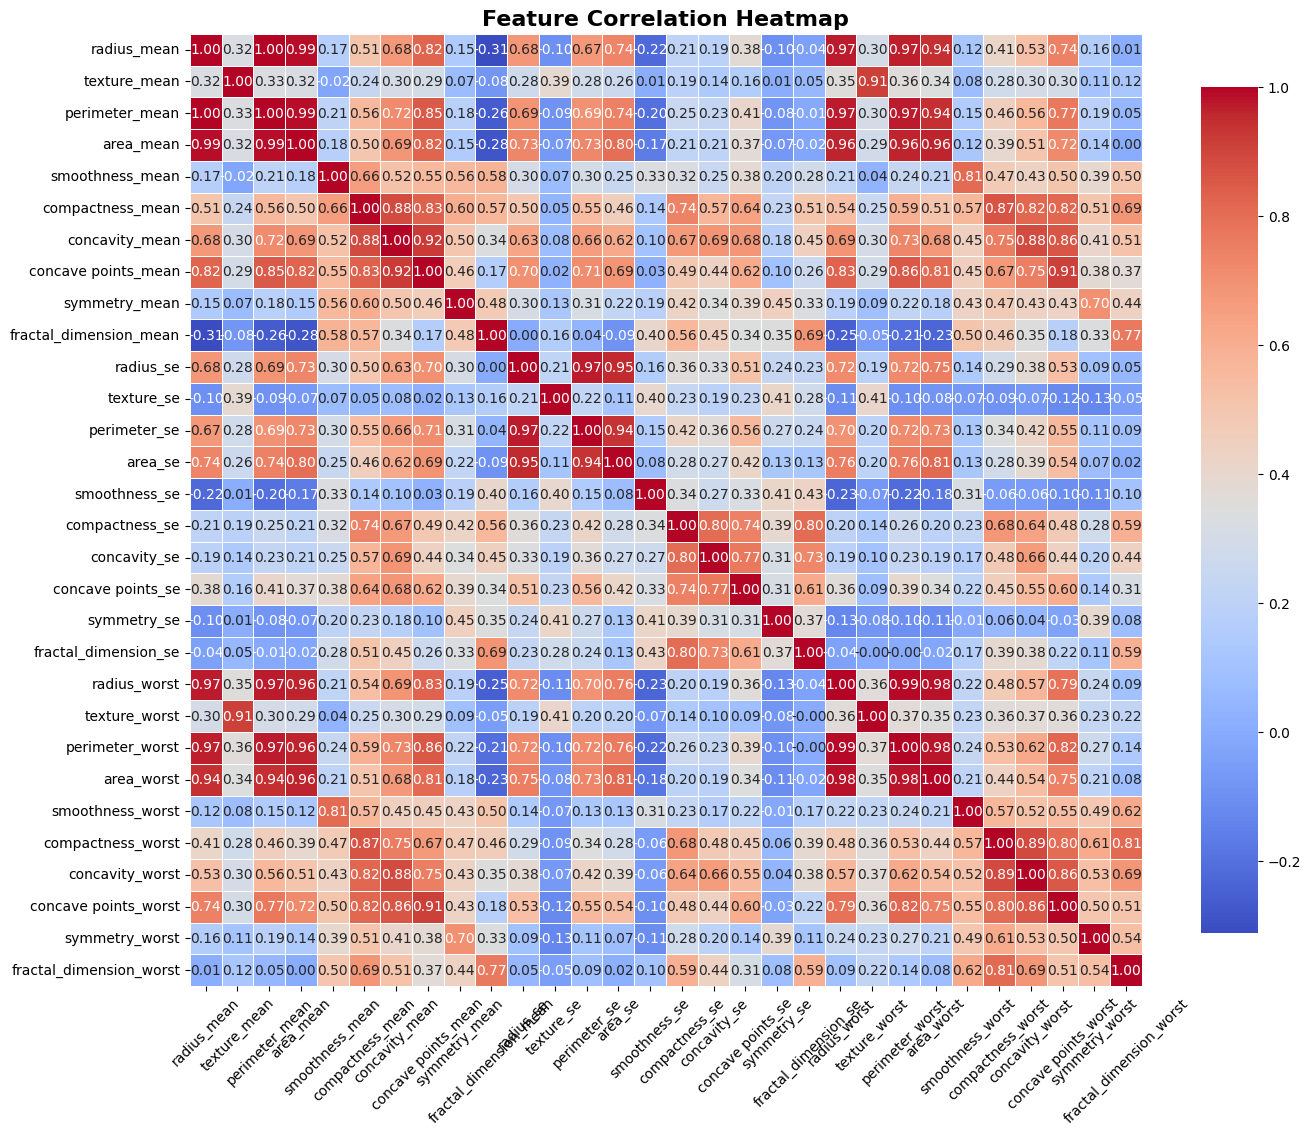

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Hyperparameters:
╒═══════════════════╤═════════╕
│ Hyperparameter    │   Value │
╞═══════════════════╪═════════╡
│ max_depth         │         │
├───────────────────┼─────────┤
│ min_samples_leaf  │       2 │
├───────────────────┼─────────┤
│ min_samples_split │       2 │
├───────────────────┼─────────┤
│ n_estimators      │     200 │
╘═══════════════════╧═════════╛
Model saved as breast_cancer_model.pkl
Model loaded successfully!

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.97        72
   Malignant       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


Confusion Matrix:
╒════════════════════╤═══════════════════════╕
│   Predicted Benign │   Predicted Malignant │
╞════════════════════╪══════════

<ipython-input-5-62660f435b85>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


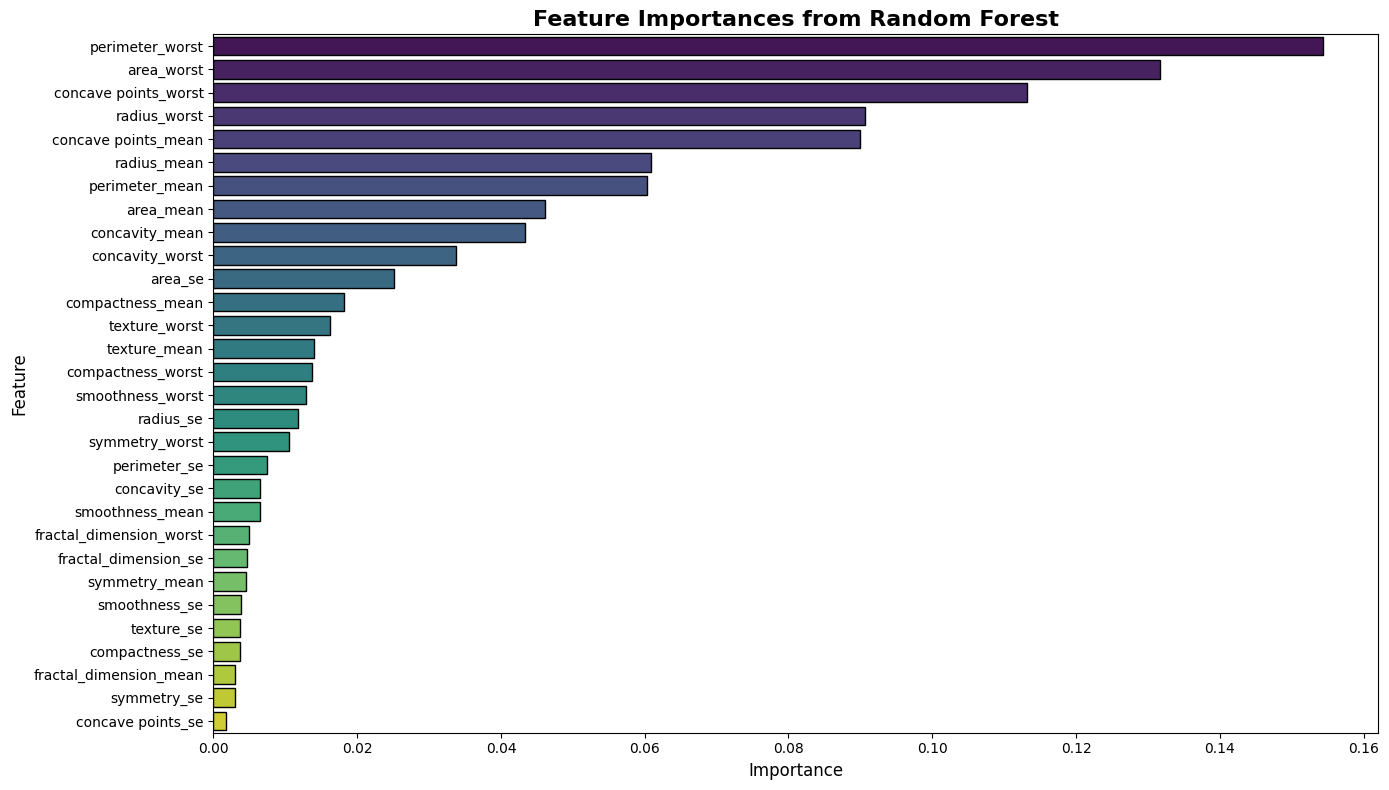

In [5]:
!pip install colorama
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from colorama import Fore, Style
from tabulate import tabulate

# Load the dataset
data = pd.read_csv("/content/BreastCancer.csv")

# Dataset overview
print(Fore.CYAN + Style.BRIGHT + "Dataset Information:" + Style.RESET_ALL)
print(data.info())

print(Fore.YELLOW + Style.BRIGHT + "\nFirst few rows of the dataset:" + Style.RESET_ALL)
print(tabulate(data.head(), headers="keys", tablefmt="fancy_grid"))

# Drop unnecessary column
if 'Unnamed: 32' in data.columns:
    data = data.drop(columns=['Unnamed: 32'])

# Check for missing values
print(Fore.MAGENTA + Style.BRIGHT + "\nMissing Values:" + Style.RESET_ALL)
missing_values = data.isnull().sum()
print(tabulate(missing_values.reset_index(), headers=["Column", "Missing Values"], tablefmt="fancy_grid"))

# Handle missing values dynamically
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy="mean")
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Split features and target
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'B': 0, 'M': 1})  # Map target labels

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = X_scaled.corr()
sns.heatmap(
    correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, square=True,
    annot_kws={"size": 10}, cbar_kws={"shrink": 0.8, "aspect": 15}
)
plt.title("Feature Correlation Heatmap", fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print(Fore.GREEN + Style.BRIGHT + "\nBest Hyperparameters:" + Style.RESET_ALL)
print(tabulate(grid_search.best_params_.items(), headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))

# Save the model
model_filename = "breast_cancer_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)
print(Fore.BLUE + f"Model saved as {model_filename}" + Style.RESET_ALL)

# Load the model
with open(model_filename, "rb") as file:
    loaded_model = pickle.load(file)
print(Fore.GREEN + "Model loaded successfully!" + Style.RESET_ALL)

# Predictions and evaluation
y_pred = loaded_model.predict(X_test)

print(Fore.YELLOW + Style.BRIGHT + "\nClassification Report:" + Style.RESET_ALL)
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

conf_matrix = confusion_matrix(y_test, y_pred)
print(Fore.MAGENTA + "\nConfusion Matrix:" + Style.RESET_ALL)
print(tabulate(conf_matrix, headers=["Predicted Benign", "Predicted Malignant"], tablefmt="fancy_grid"))

accuracy = accuracy_score(y_test, y_pred)
print(Fore.CYAN + f"\nModel Accuracy: {accuracy:.2%}" + Style.RESET_ALL)

# Feature importances
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=feature_importances.values, y=feature_importances.index, palette="viridis",
    edgecolor="black"
)
plt.title("Feature Importances from Random Forest", fontsize=16, weight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()
